In [2]:
from tarfile import data_filter

import pandas as pd
import numpy as np
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from dask.dataframe import read_csv
from matplotlib.pyplot import xticks
from numpy.ma.core import cumsum
from pandas.core.interchange.dataframe_protocol import DataFrame
from ply.cpp import xrange
from pygments.lexer import bygroups

import volpy_func_lib as vp
import load_clean_lib
import table_lib
import vol_strat_lib as vs

from datetime import datetime
from volpy_func_lib import load_forward_price

In [13]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)

<module 'vol_strat_lib' from 'D:\\Professionelt\\Code\\volpy\\vol_strat_lib.py'>

# Load Data

In [4]:
profile = "Mads"
om_folder = "i2s1_full_v2"
sum_df, od_raw = vs.import_sum_raw(profile = profile, om_folder = om_folder)

In [5]:
price_type = "mid"
IV_type = "om"

od_hl = vs.create_od_hl(od_raw = od_raw, sum_df = sum_df, price_type = price_type, IV_type = IV_type)
sum_df = vs.add_F_to_sum_df(od_hl = od_hl, sum_df = sum_df)

# Find and add ATM options to sum_df

In [6]:
# Define processing configurations
configs = [
    ('low', 'C', 'low_call'),
    ('low', 'P', 'low_put'),
    ('high', 'C', 'high_call'),
    ('high', 'P', 'high_put'),
]

# Process all combinations
pivoted_dfs = [vs.process_options_ATM(od_hl, low_high, cp_flag, prefix) 
              for low_high, cp_flag, prefix in configs]

# Merge all results
for p_df in pivoted_dfs:
    sum_df = sum_df.merge(p_df, on=['ticker', 'date'], how='left')

# Add next price of options to sum_df

In [7]:
# Create next price lookup
od_sorted = od_raw.sort_values(['optionid', 'date']).copy()
od_sorted['price_next'] = od_sorted.groupby('optionid')['price'].shift(-1)
next_price_lookup = od_sorted[['ticker', 'date', 'optionid', 'price_next']]

# Add next prices to all option columns
sum_df = vs.add_next_prices(sum_df, next_price_lookup)

In [8]:
sum_SPX = sum_df[sum_df["ticker"] == "SPX"].reset_index(drop=True)

# Calculate strategy cashflow

In [22]:
# Put and Call (in USD)
for put_call in ["put", "call"]:
    for low_high in ["low", "high"]:
        sum_SPX[f"free_{low_high}_{put_call}"] = (
            sum_SPX[f"{low_high}_{put_call}_1_price_next"] - (1+sum_SPX[f"RF"]) * sum_SPX[f"{low_high}_{put_call}_price_1"]
        ).shift(1)

# Straddle        
for low_high in ["low", "high"]:
    sum_SPX[f"free_{low_high}_straddle"] = sum_SPX[f"free_{low_high}_put"] + sum_SPX[f"free_{low_high}_call"]

In [23]:
# Delta hedged Put and Call (in USD)
for put_call in ["put", "call"]:
    for low_high in ["low", "high"]:
        sum_SPX[f"free_D_{low_high}_{put_call}"] = (
            sum_SPX[f"{low_high}_{put_call}_1_price_next"] - (1+sum_SPX[f"RF"]) * sum_SPX[f"{low_high}_{put_call}_price_1"] - 
            sum_SPX[f"{low_high}_{put_call}_delta_1"] * sum_SPX[f"close"] * (sum_SPX[f"return"].shift(-1) - sum_SPX[f"RF"]) # Delta hedge (self financed)
        ).shift(1)

# Delta hedged Straddle        
for low_high in ["low", "high"]:
    sum_SPX[f"free_D_{low_high}_straddle"] = sum_SPX[f"free_D_{low_high}_put"] + sum_SPX[f"free_D_{low_high}_call"]

In [24]:
# # Put and Call
# for put_call in ["put", "call"]:
#     for low_high in ["low", "high"]:
#         sum_SPX[f"r_{low_high}_{put_call}"] = (
#                 sum_SPX[f"{low_high}_{put_call}_1_price_next"] / sum_SPX[f"{low_high}_{put_call}_price_1"] - 1
#         ).shift(1)

# # Straddle
# for low_high in ["low", "high"]:
#     sum_SPX[f"r_{low_high}_straddle"] = (
#             (sum_SPX[f"{low_high}_call_1_price_next"] + sum_SPX[f"{low_high}_put_1_price_next"]) / 
#             (sum_SPX[f"{low_high}_call_price_1"]      + sum_SPX[f"{low_high}_put_price_1"])-1
#     ).shift(1)

In [85]:
T1 = sum_SPX["low days"].shift(1)
T2 = sum_SPX["high days"].shift(1)

sum_SPX["30_straddle"] = vs.T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX[f"free_low_straddle"], r2 = sum_SPX[f"free_high_straddle"])
sum_SPX["30_D_straddle"] = vs.T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX[f"free_D_low_straddle"], r2 = sum_SPX[f"free_D_high_straddle"])

for put_call in ["put", "call"]:
    sum_SPX[f"30_D_{put_call}"] = vs.T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX[f"free_D_low_{put_call}"], r2 = sum_SPX[f"free_D_high_{put_call}"])
    sum_SPX[f"30_{put_call}"] = vs.T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX[f"free_low_{put_call}"], r2 = sum_SPX[f"free_high_{put_call}"])

In [86]:
sum_SPX["Mkt_change_free"] = sum_SPX[f"close"].diff()-sum_SPX[f"close"].shift(1)*sum_SPX[f"RF"]

# No hedge

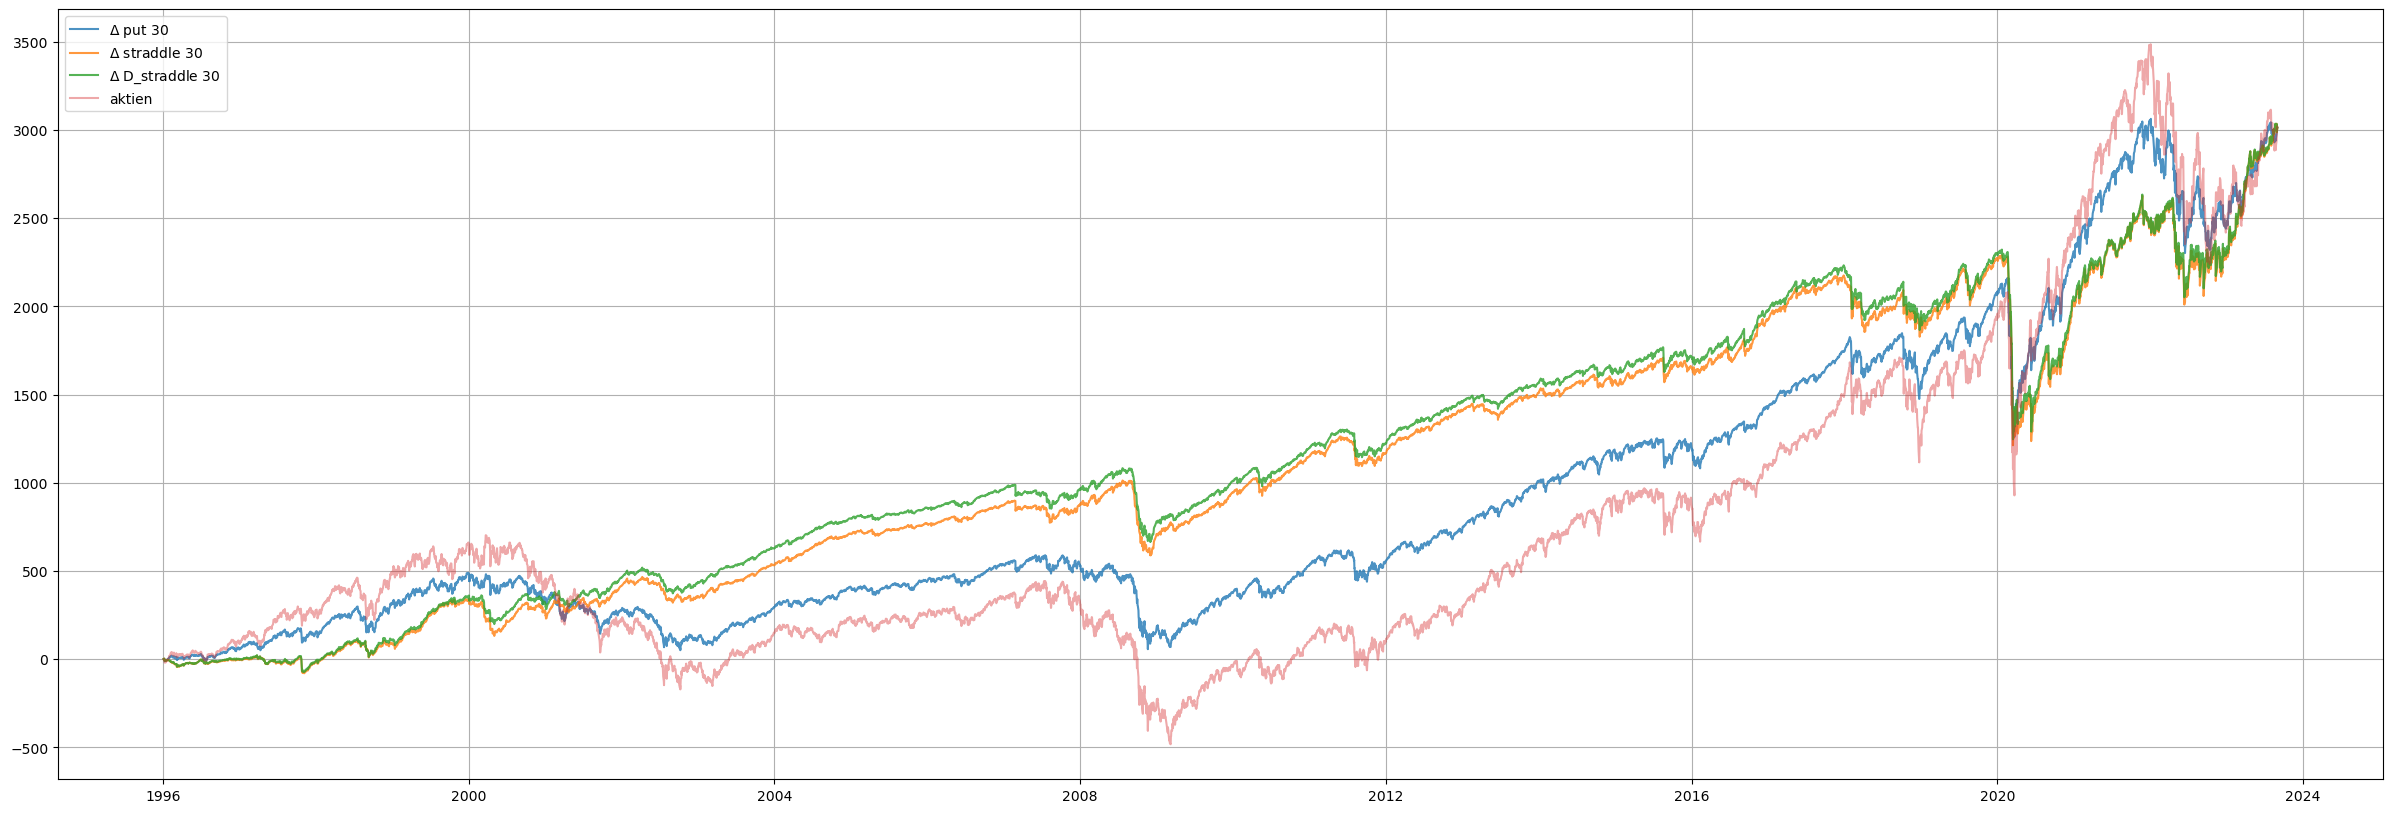

In [90]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]
    
for put_call in ["put", "straddle", "D_straddle"]:
    last_option_val = np.cumsum(sum_SPX[f"30_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"30_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30", alpha=0.8)

plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()

# Plot accumulated cashflow

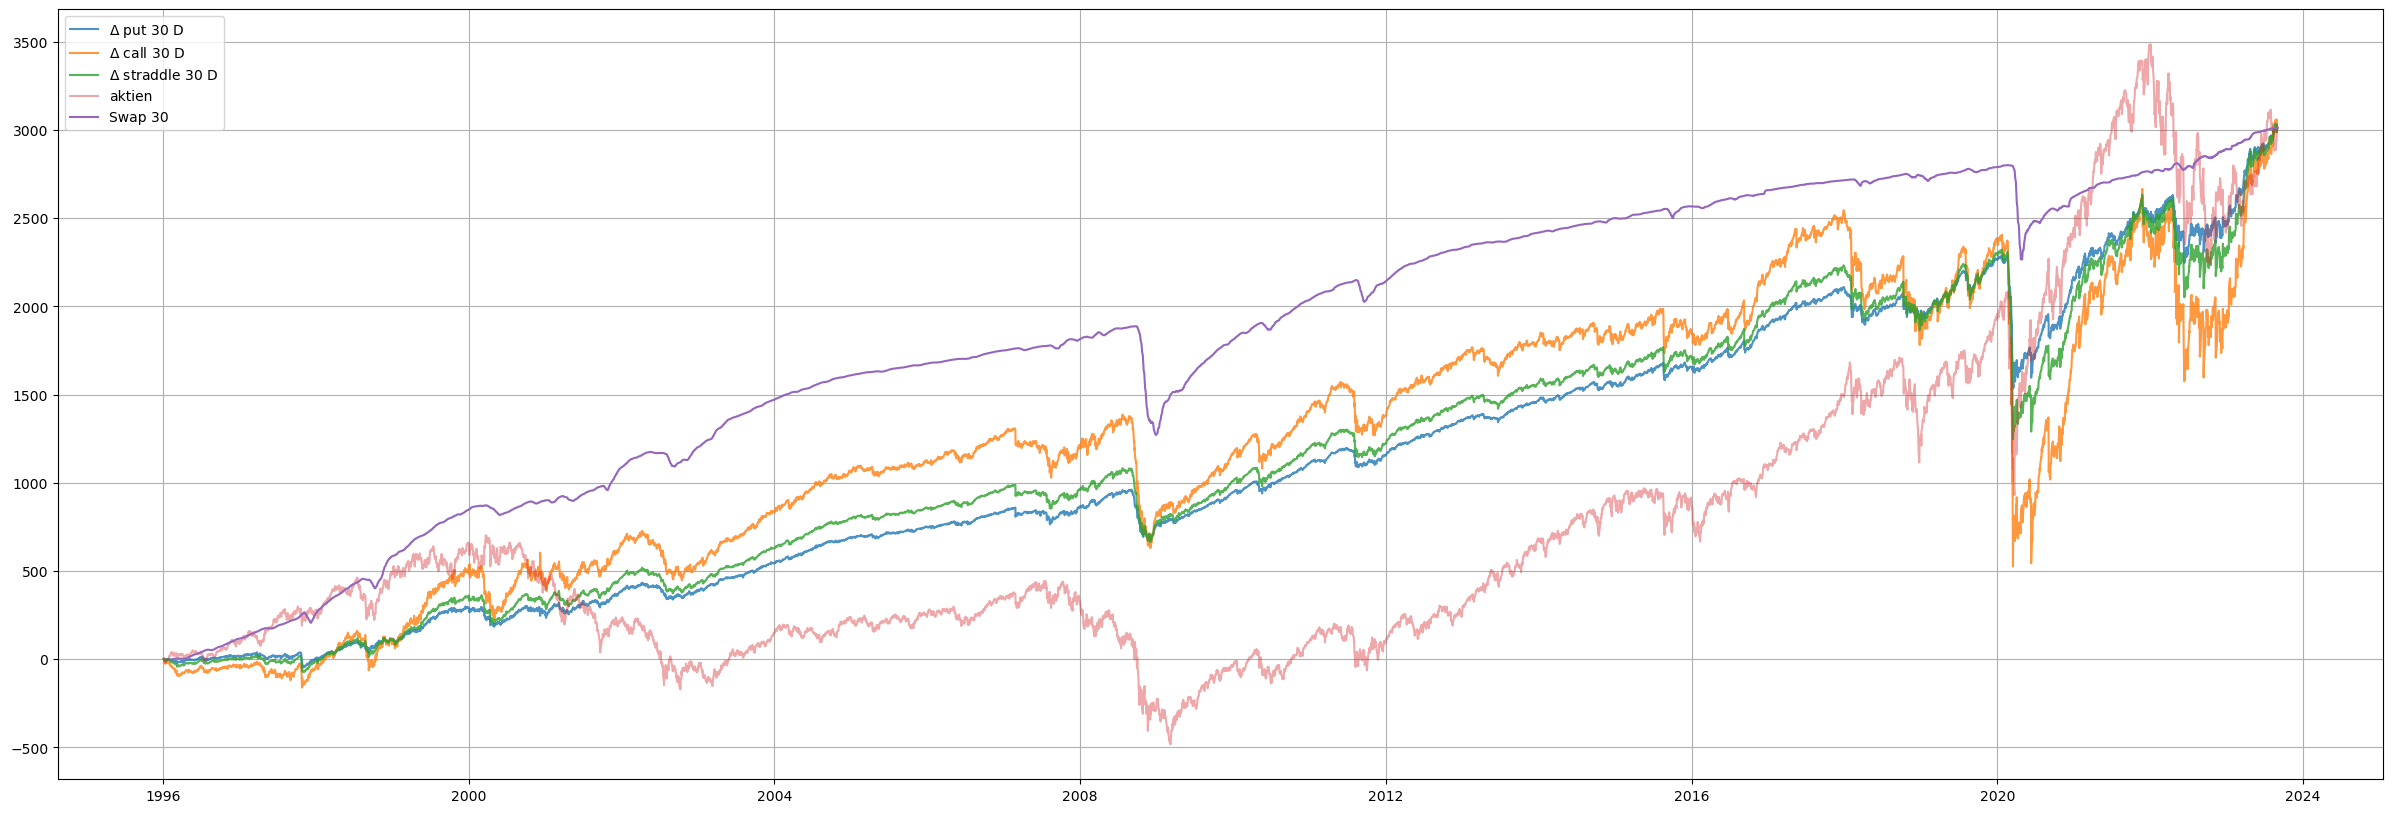

In [109]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]
    
for put_call in ["put", "call", "straddle"]:
    last_option_val = np.cumsum(sum_SPX[f"30_D_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"30_D_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
    label="aktien", alpha=0.4)

x_SW = sum_SPX["SW_month"]
last_val = np.cumsum(x_SW).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(sum_SPX["date"], scalar * np.cumsum(x_SW), label = "Swap 30")

plt.grid()
plt.legend()
plt.show()

# Other figures

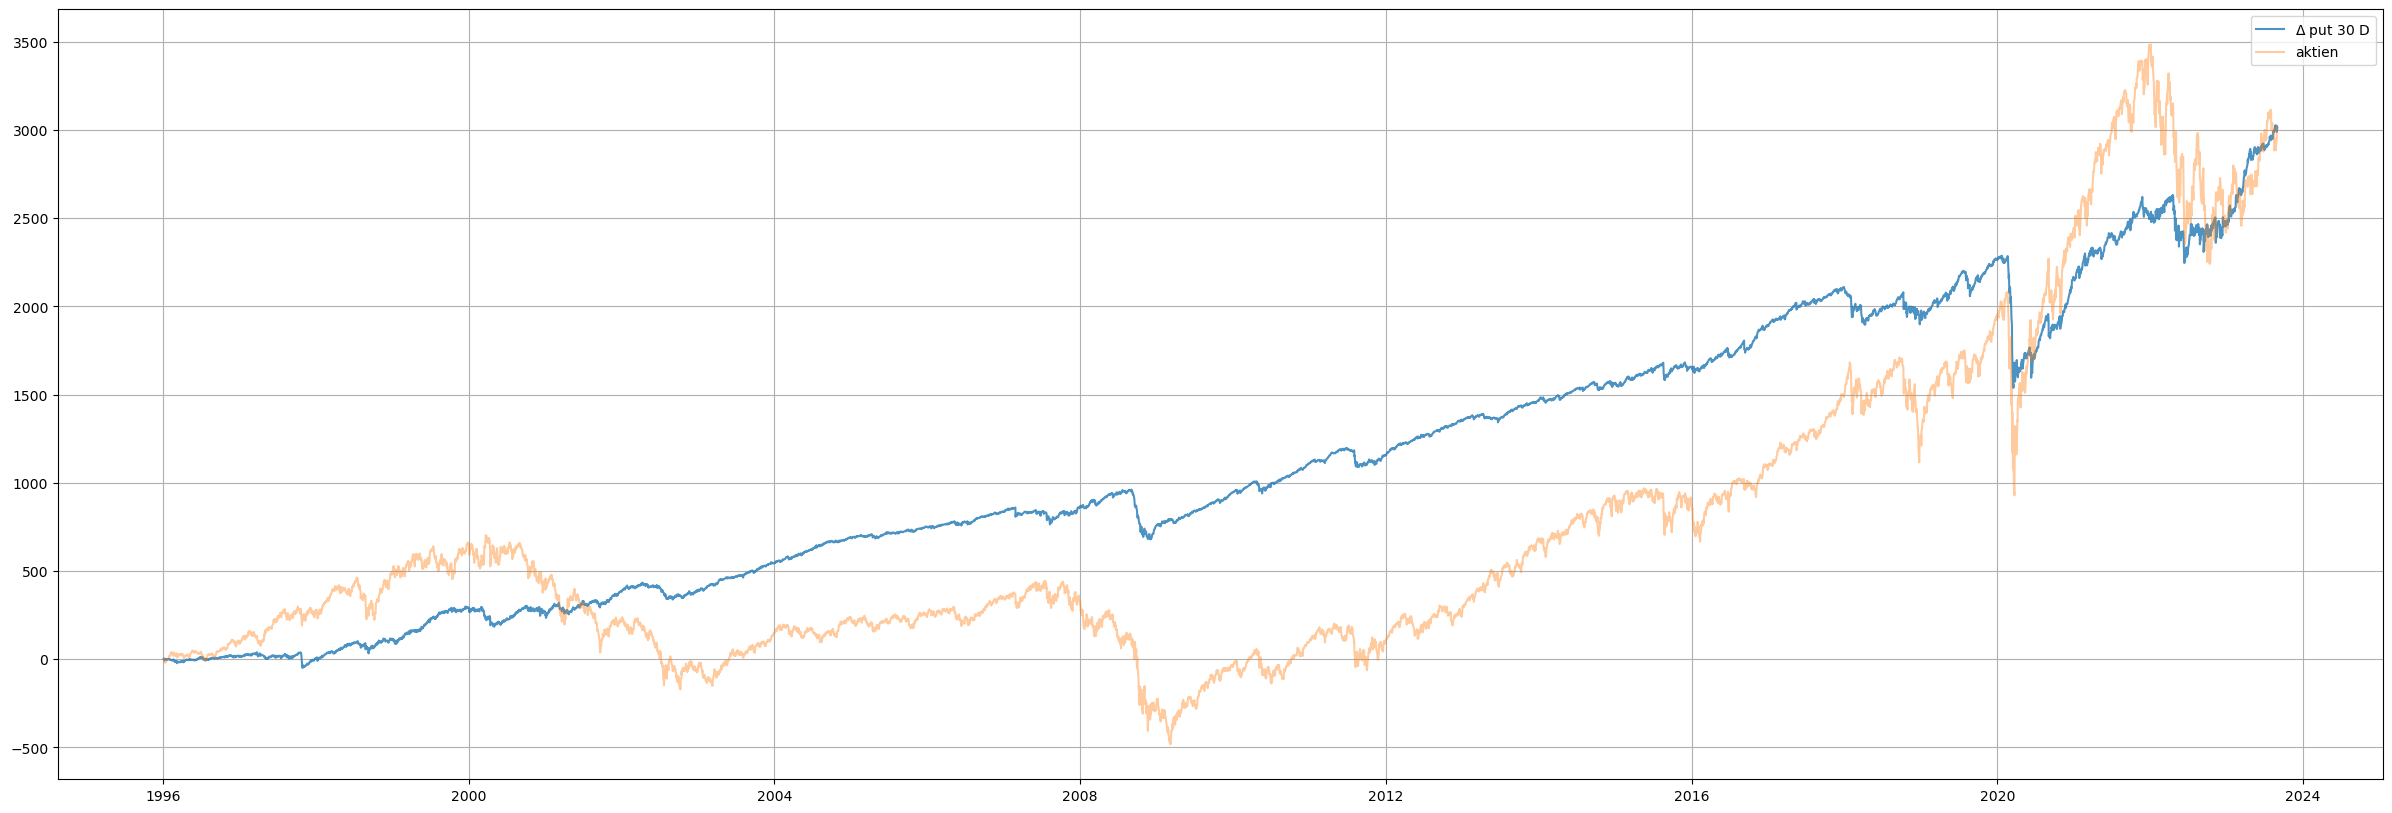

In [78]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]

put_call = "put"

for low_high in ["low", "high"]:
    last_option_val = np.cumsum(sum_SPX[f"free_D_{low_high}_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"free_D_{low_high}_{put_call}"]),
         label=rf"$\Delta$ {put_call} " + low_high + " D", alpha=0.8)
    
last_option_val = np.cumsum(sum_SPX[f"30_D_{put_call}"]).iloc[-1]
scalar = last_stock_val/last_option_val

plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"30_D_{put_call}"]),
     label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()